In [1]:
# Definitions and functions
%matplotlib inline
import pdb
import sys
import pandas as pd
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as sg
import math
import scipy as sp
import socket
import os
import wave
import struct
import h5py
from scipy.io import wavfile
from scipy.signal import spectrogram
import logging
from IPython.display import display
matplotlib.style.use('ggplot')
from ipywidgets import *
import yaml
import numpy.lib.recfunctions as rfn 
import numpy.matlib as npm
import glob

# Check wich computer to decide where the things are mounted
comp_name=socket.gethostname()
print 'Computer: ' + comp_name

if 'txori' in comp_name or 'passaro' in comp_name or 'lintu' in comp_name:
    repos_folder = os.path.abspath('/mnt/cube/earneodo/repos')
    experiment_folder = os.path.join('/mnt/cube/earneodo/bci_zf/')

sys.path.append(os.path.join(repos_folder, 'ephysflow'))
#sys.path.append(os.path.join(repos_folder, 'analysis-tools'))
sys.path.append(os.path.join(repos_folder, 'swissknife'))

from bci.core import expstruct as et

from basic_viewing import events as evt
from basic_viewing.units import Unit
from basic_viewing.structure.core.basic_plot import plot_raster, sparse_raster
from basic_viewing.structure.core import basic_plot as bp

from basic_viewing.structure import kwik_functions as kwkf
from basic_viewing.structure.core import h5_functions as kwdf

from h5tools import h5tools as h5
from streamtools import streams as st
from streamtools import spectral as sp
from streamtools import temporal as tp

logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter(
        '%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

def list_sum(a_list):
    s = a_list.pop(-1)
    for new_s in a_list:
        s+=new_s
    return s

print 'All modules loaded'

Computer: passaro
All modules loaded


In [2]:
# bird and session
bird = 'z007'
sess = 'day-2016-09-10'
stim_sess = '001'

spectrogram_pars={'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 10000,
                 'db_cut': 0.000065 }

filter_band = [500, 10000]

def band_pass_filter(chunk, hp_b, hp_a, lp_b, lp_a):    
    chunk_hi = sg.filtfilt(hp_b, hp_a, chunk)
    chunk_filt = sg.filtfilt(lp_b, lp_a, chunk_hi)
    return chunk_filt
    
exp_par = et.get_parameters(bird, sess)
fn = et.file_names(bird, sess)
song_file_path = et.file_path(fn, 'ss', 'sng')
song_file = h5py.File(song_file_path, 'r')

pattern_names = exp_par['search_motiff']['motiff_patterns']
print pattern_names

{'motiff_1': 'motiff_1.wav'}


550.4
fcut_plot 10000


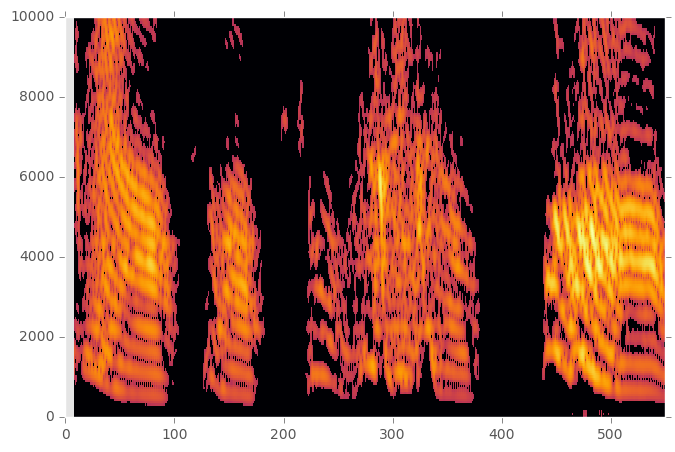

In [3]:
reload(sp)
#pattern
m_name = 'motiff_1'
m_path = os.path.join(et.file_names(bird)['folders']['stim'], stim_sess, 
                      exp_par['search_motiff']['motiff_patterns'][m_name])

m = evt.Song(m_name, song_file)
m_chunk = st.Chunk(st.WavData2(m_path))
#plt.plot(m_chunk.data)

s_f = m_chunk.sound.s_f
filter_pars = sp.make_butter_bandpass(s_f, filter_band[0], filter_band[1])

spec_obj = sp.Spectrogram(m_chunk.data[:,0], s_f, **spectrogram_pars)
ax = spec_obj.plot()

(<matplotlib.figure.Figure at 0x7f1f0999a310>,
 <matplotlib.axes._axes.Axes at 0x7f1ef6f9fd90>)

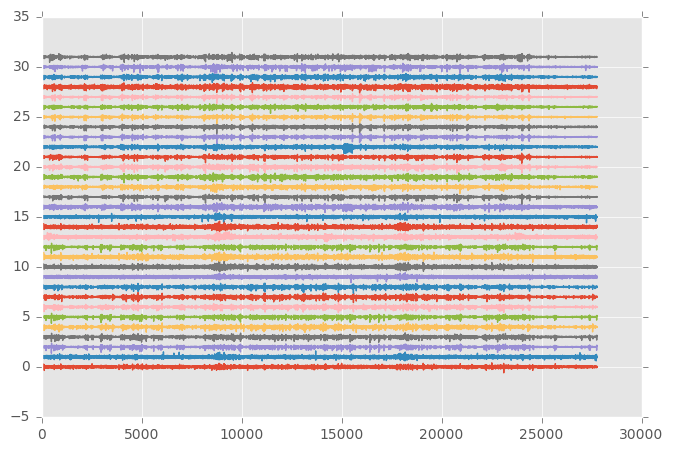

In [9]:
reload(st)
kwd_file = et.open_kwd(bird, sess)
starts = m.get_start()
recs = m.get_rec()

lfp_spectro_pars={'n_window': 512,
                 'n_overlap': 511,
                 'sigma': 30,
                 'f_cut': 150,
                 'db_cut': 0.000065 }

m_starts = kwkf.apply_rec_offset(kwd_file, m.get_start(), m.get_rec())

i_bout = 29
#neural_chans = np.array(exp_par['channel_config']['neural'] + [exp_par['channel_config']['mic']])
neural_chans = np.array(exp_par['channel_config']['neural'])
before = 5000
after = 6000
#neural_chans = np.array([19, 23, 25, 26, 27, 29])
rec = recs[i_bout]
dset = kwdf.get_data_set(kwd_file, rec)
h5d = st.H5Data(dset, s_f, dtype=np.float, chan_list=neural_chans)
start = starts[i_bout]

lfp_frame = st.Chunk(h5d, chan_list = h5d.chan_list, segment=[start-before, start + m_chunk.samples + after])
lfp_frame.apply_filter(sp.apply_butter_bandpass, filter_pars)

lfp_frame.plot()

In [10]:
def collect_frames(starts, span, s_f, kwd_file, recs_list, chan_list):
    frames = []

    logger.info('Collecting {} frames...'.format(starts.size))
    for i_start, start in enumerate(starts):
        if i_start % 10 == 0:
            logger.info("Frame {} ...".format(i_start))
        rec = recs_list[i_start]
        one_frame = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec),
                                       s_f,
                                       dtype=np.float),
                             np.array(chan_list),
                             [start, start + span])
        frames.append(one_frame)
    return frames

all_frames = collect_frames(starts-before, before+after+m_chunk.samples, 
                            s_f, 
                            kwd_file, recs, neural_chans)

2016-12-09 11:50:46,917 root         INFO     Collecting 71 frames...
2016-12-09 11:50:46,919 root         INFO     Frame 0 ...
2016-12-09 11:50:47,018 root         INFO     Frame 10 ...
2016-12-09 11:50:47,097 root         INFO     Frame 20 ...
2016-12-09 11:50:47,164 root         INFO     Frame 30 ...
2016-12-09 11:50:47,233 root         INFO     Frame 40 ...
2016-12-09 11:50:47,299 root         INFO     Frame 50 ...
2016-12-09 11:50:47,365 root         INFO     Frame 60 ...
2016-12-09 11:50:47,434 root         INFO     Frame 70 ...


In [11]:
#lfp_frame.apply_filter(np.linalg.norm, axis=0)
# get the rms vector

def filter_rms(x, filter_pars):
    return st.rms(sp.apply_butter_bandpass(x, filter_pars))
    
rms = h5d.get_rms(window_size_samples=50000, n_windows=10000, rms_func=filter_rms, rms_args = (filter_pars,))


In [13]:
spike_thresh = 2.5
thresh = rms*spike_thresh
print(thresh)

[ 185.52009792  232.62657973  260.07287876  262.61409503  318.44532119
  258.19592292  322.54394133  277.44834128  268.51415497  239.01920399
  173.75964161  196.75810222  245.03728156  225.2344436   180.41055744
  246.16193118  239.40124075  319.61009311  273.43061752  289.48419641
  300.00418546  308.23847556  240.62139662  272.90763576   93.59478622
  277.01674695  282.17134949  290.15984787  161.56030422  275.16928169
  280.12445578  289.44182944]


In [33]:
tfr.data.shape

(1100, 6)

In [28]:
tfr=st.Chunk(h5d, np.array(neural_chans), [start-5000, start + 6000])
tfr.apply_filter(sp.apply_butter_bandpass, filter_pars)
found_spikes = tp.find_spikes(tfr.data, thresh)

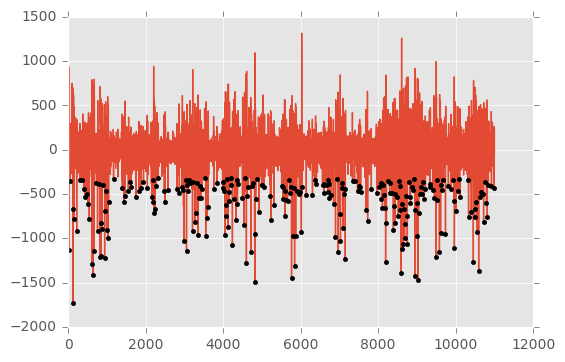

In [29]:
plt.plot(tfr.data[:, chan])
plt.plot(found_spikes[chan], tfr.data[found_spikes[chan], chan], 'k.')

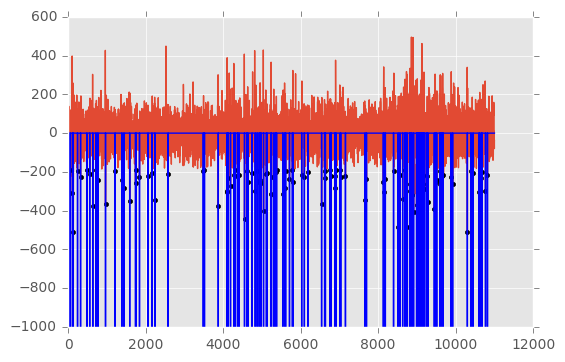

In [32]:
chan = 0
plt.plot(tfr.data[:, chan])
plt.plot(found_spikes[chan], tfr.data[found_spikes[chan], chan], 'k.')
sarr = spikes_array(tfr, thresh)
plt.plot(sarr[:, chan]*(-1000), 'b')

In [22]:
def spikes_array(chunk, thresholds, min_dist=10):
    #logger.info('Getting spikes from chunk with data sized {}'.format(chunk.data.shape))
    spk_lst = tp.find_spikes(chunk.data, thresholds, min_dist=min_dist)
    spk_arr = np.zeros_like(chunk.data)
    assert(len(spk_lst)==spk_arr.shape[1])
    for ch in range(len(spk_lst)):
        spk_arr[spk_lst[ch], ch] = 1
    return spk_arr


tfr=st.Chunk(h5d, np.array(neural_chans), [start-100, start + 1000])
tfr.apply_filter(sp.apply_butter_bandpass, filter_pars)
sarr = spikes_array(tfr, thresh)

2016-12-10 16:08:55,860 root         INFO     Collecting 71 frames...
2016-12-10 16:08:55,863 root         INFO     Frame 0 ...
2016-12-10 16:08:55,956 root         INFO     Frame 10 ...
2016-12-10 16:08:56,043 root         INFO     Frame 20 ...


[ 185.52009792  232.62657973  260.07287876  262.61409503  318.44532119
  258.19592292  322.54394133  277.44834128  268.51415497  239.01920399
  173.75964161  196.75810222  245.03728156  225.2344436   180.41055744
  246.16193118  239.40124075  319.61009311  273.43061752  289.48419641
  300.00418546  308.23847556  240.62139662  272.90763576   93.59478622
  277.01674695  282.17134949  290.15984787  161.56030422  275.16928169
  280.12445578  289.44182944]


2016-12-10 16:08:56,116 root         INFO     Frame 30 ...
2016-12-10 16:08:56,179 root         INFO     Frame 40 ...
2016-12-10 16:08:56,241 root         INFO     Frame 50 ...
2016-12-10 16:08:56,303 root         INFO     Frame 60 ...
2016-12-10 16:08:56,365 root         INFO     Frame 70 ...


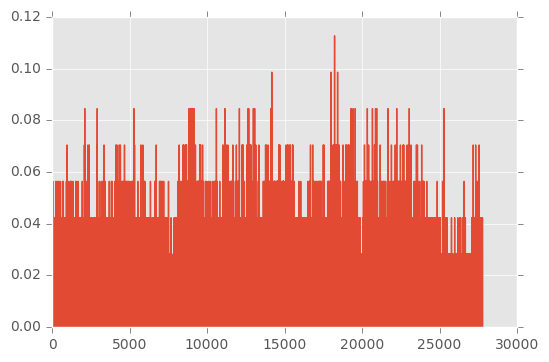

In [40]:
def collect_all_spk_arr(frames_list, thresholds, min_dist=10):
    return np.stack([spikes_array(fr, thresholds, min_dist=min_dist) for fr in frames_list], axis=0)

spike_thresh = 2.5
thresh = rms*spike_thresh
print(thresh)

all_frames = collect_frames(starts-before, before+after+m_chunk.samples, 
                            s_f, 
                            kwd_file, recs, neural_chans)
[fr.apply_filter(sp.apply_butter_bandpass, filter_pars) for fr in all_frames]
all_spk_arr = collect_all_spk_arr(all_frames, thresh)
#all_spk_arr = np.stack(all_spk_lst, axis=0)
plt.plot(all_spk_arr.mean(axis=0)[:,0])

(<matplotlib.collections.PathCollection at 0x7f1e950564d0>,
 <matplotlib.axes._axes.Axes at 0x7f1eb35ac2d0>)

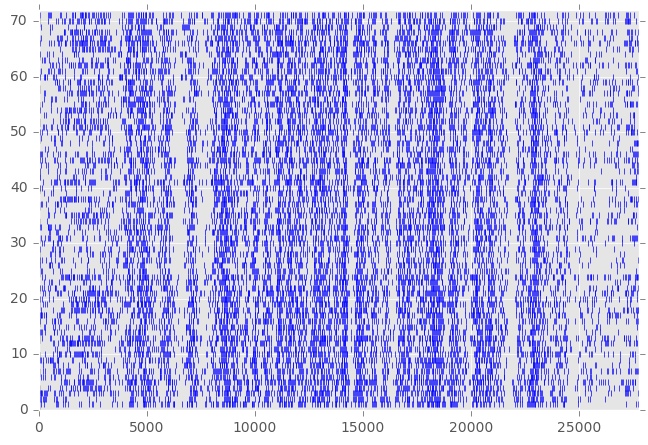

In [63]:
all_spk_arr.shape
bp.plot_raster(all_spk_arr[:,:,7])

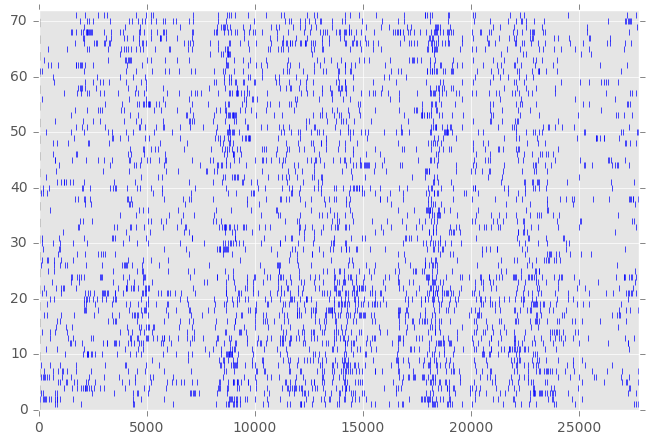

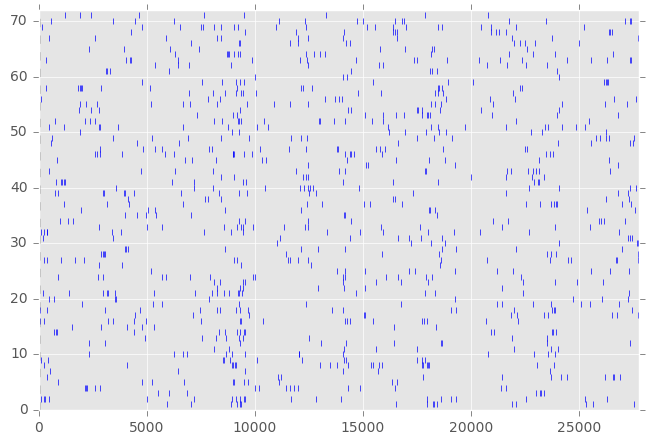

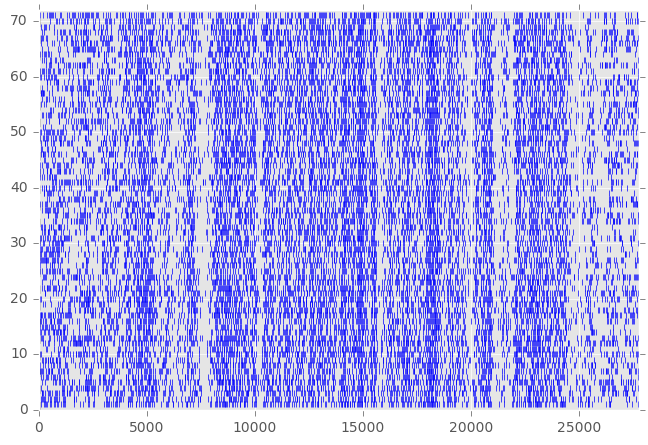

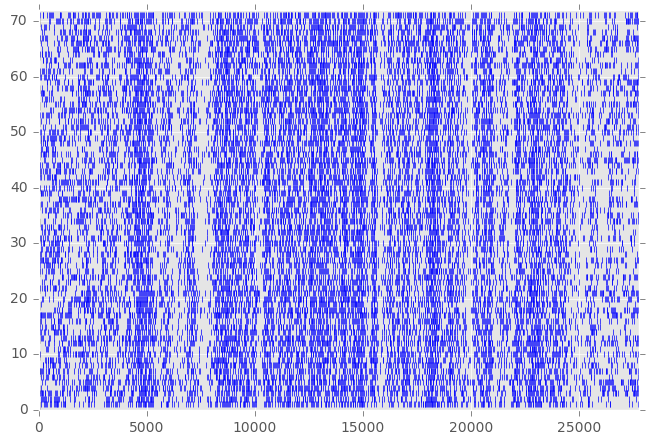

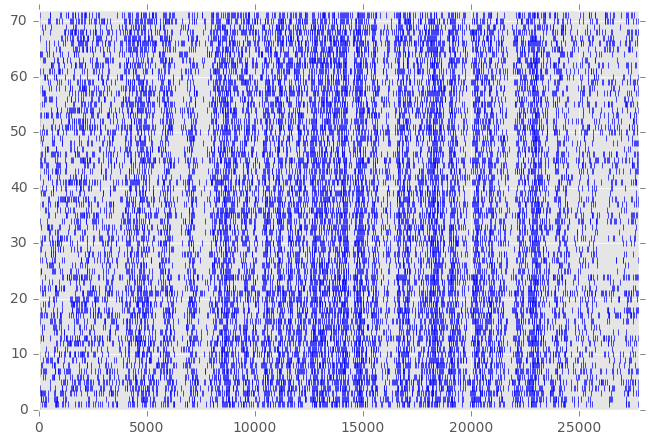

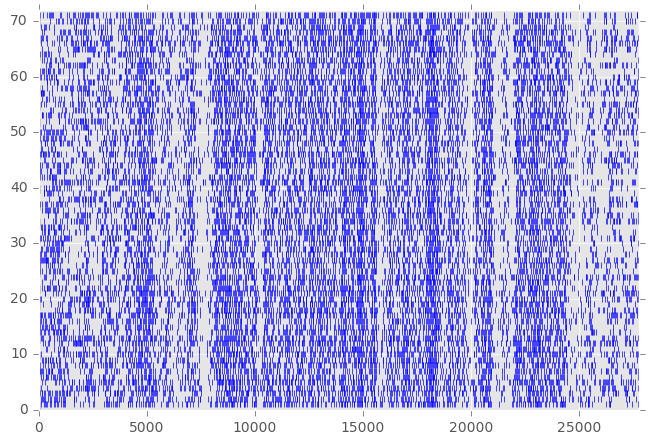

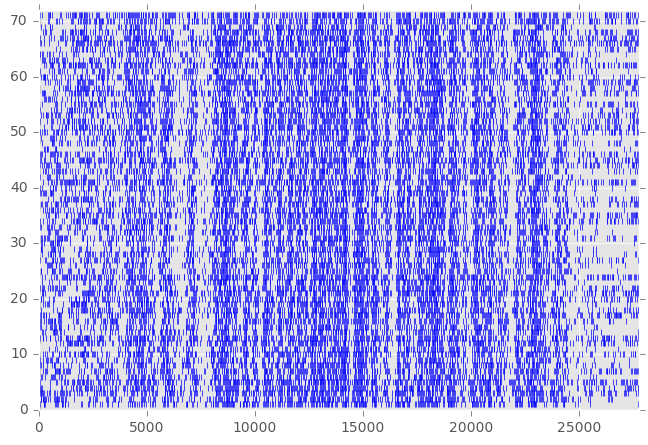

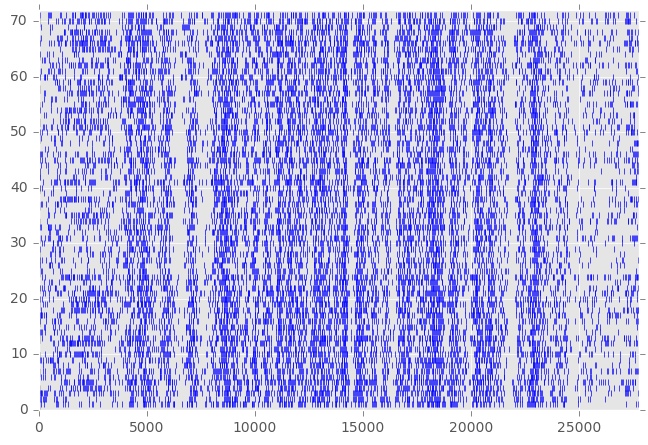

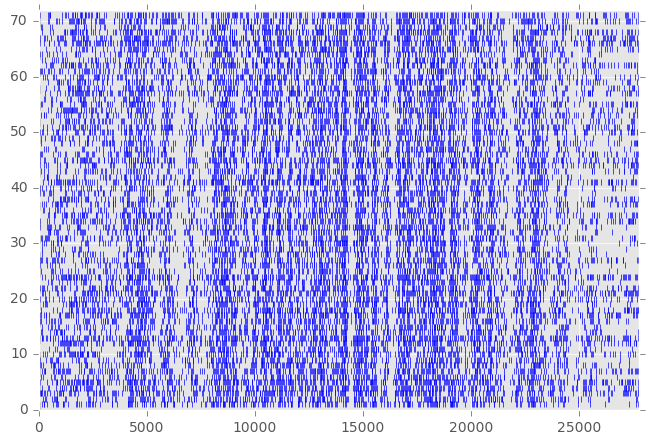

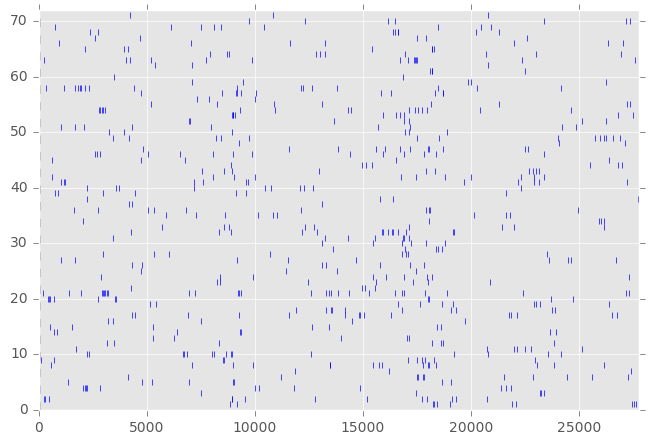

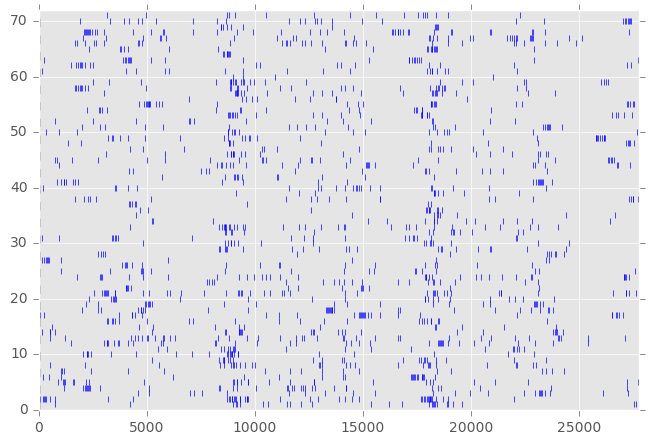

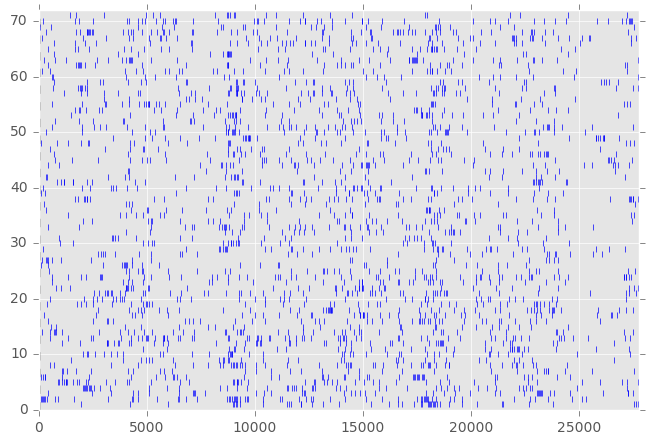

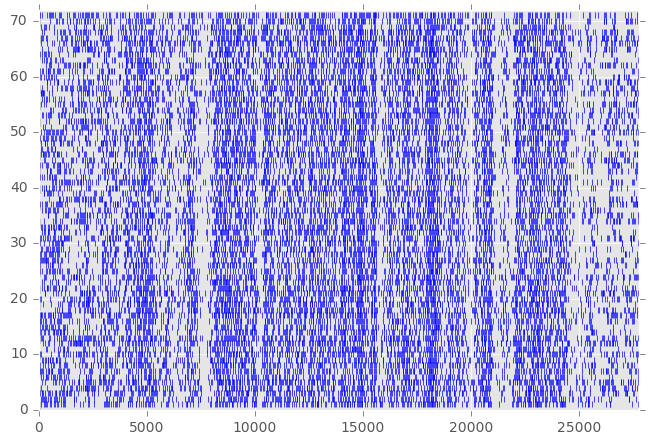

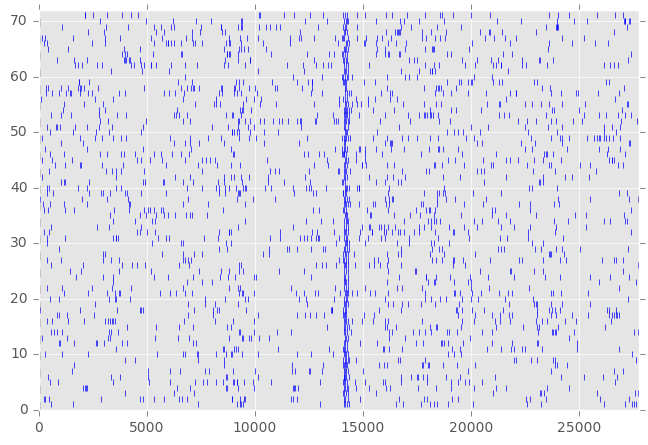

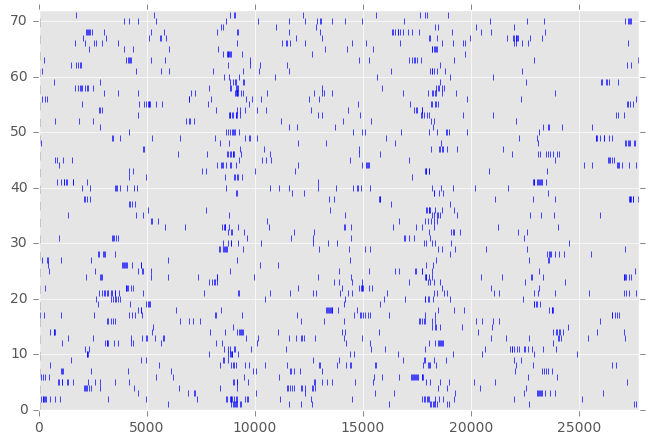

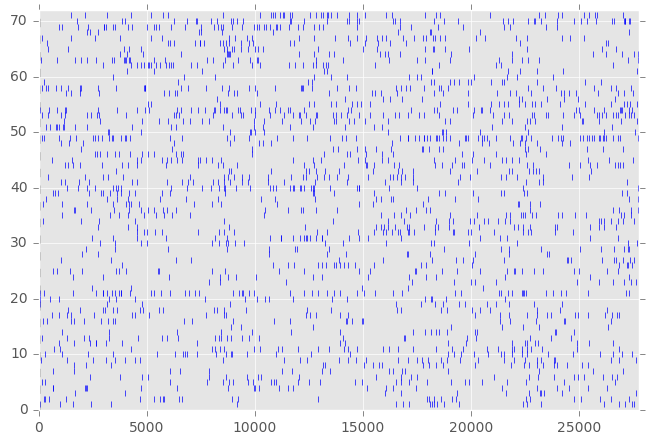

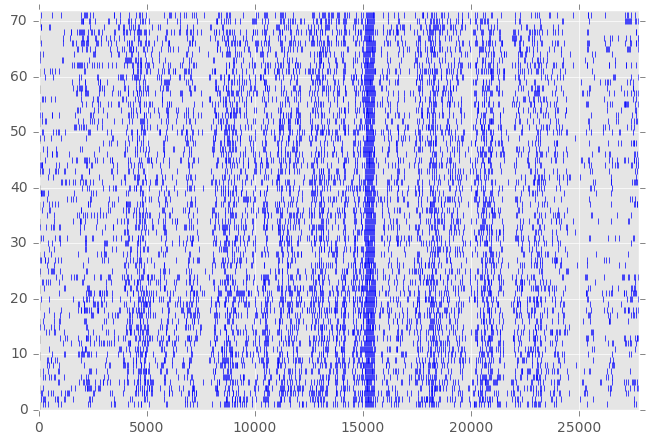

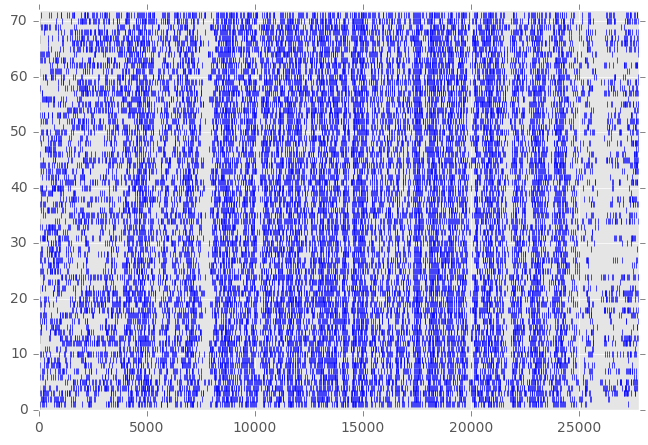

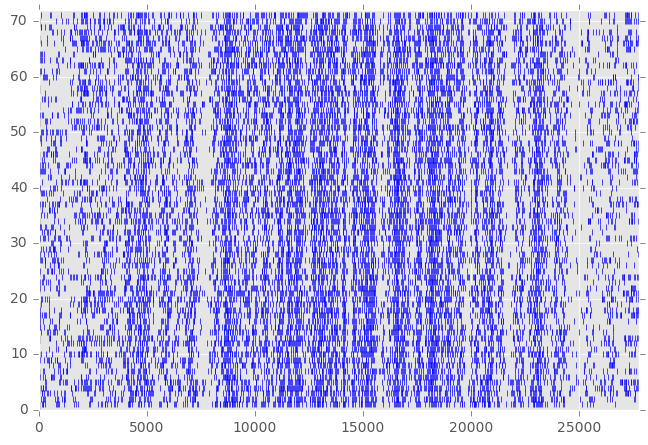

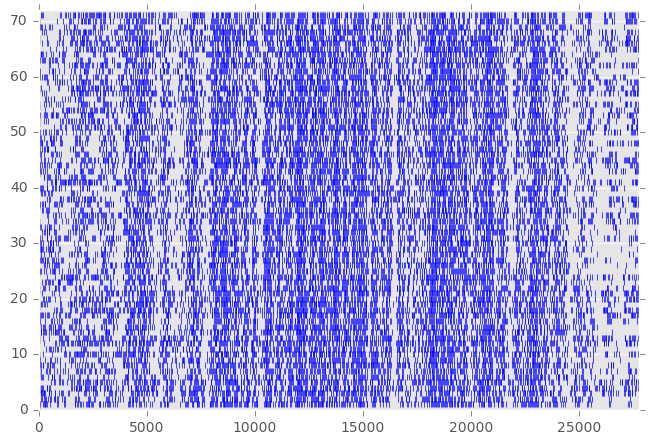

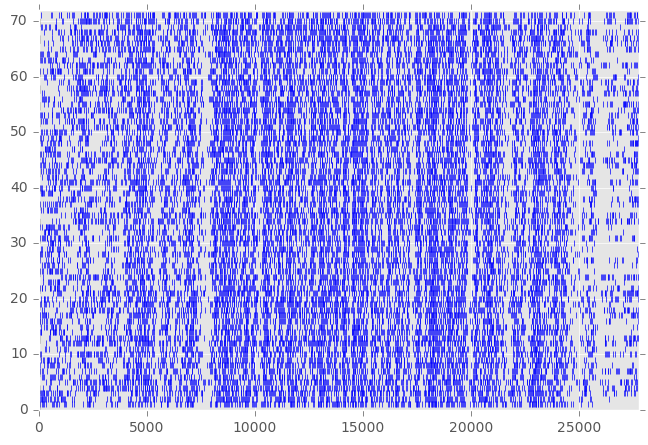

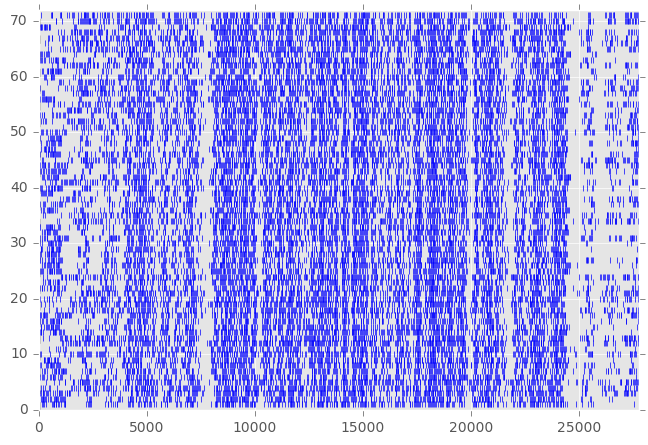

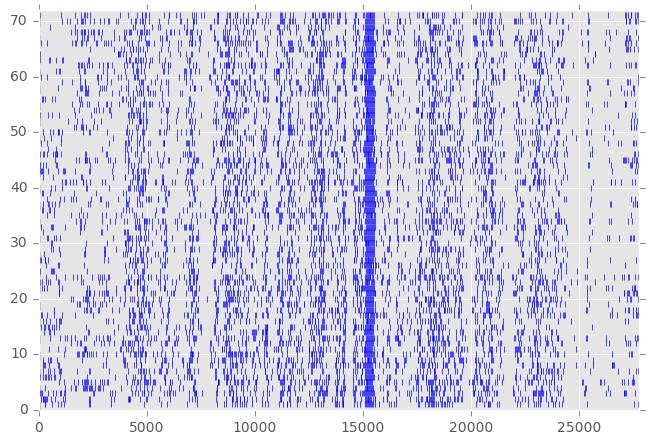

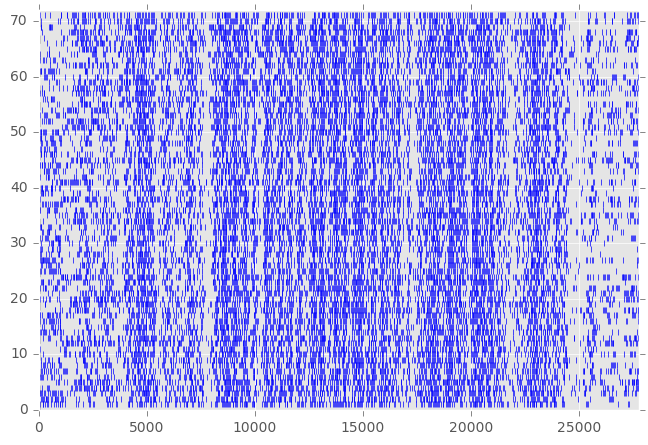

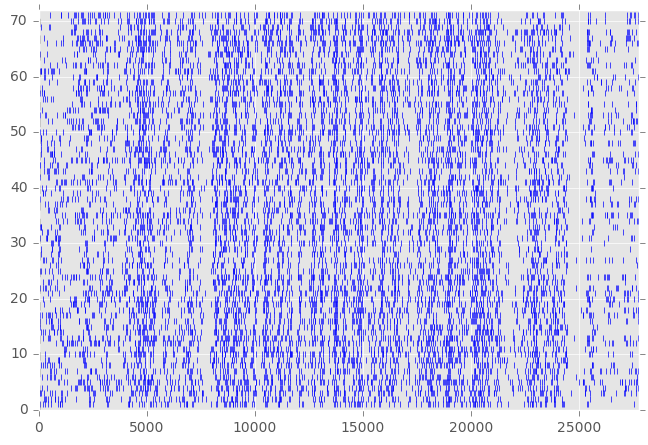

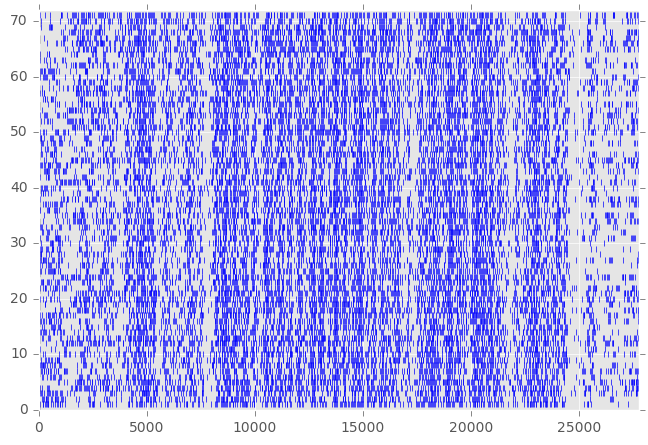

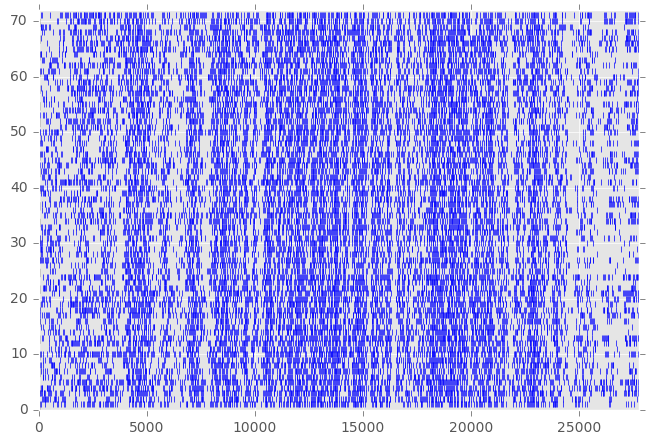

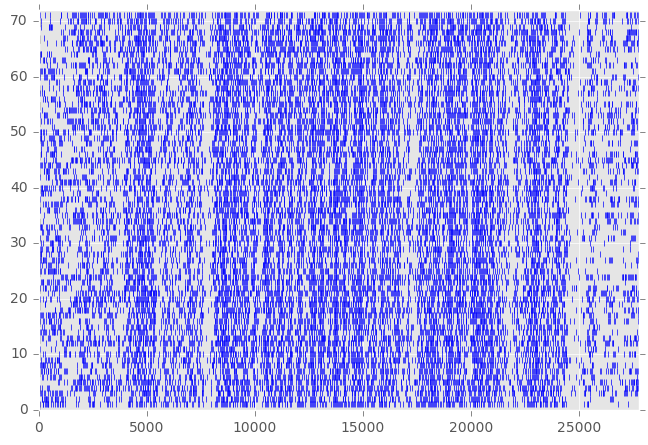

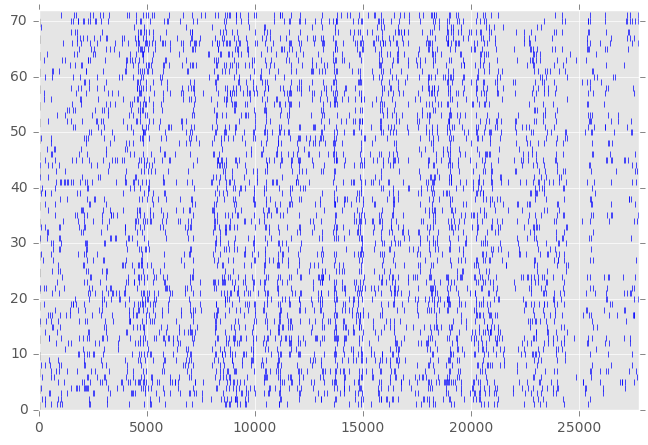

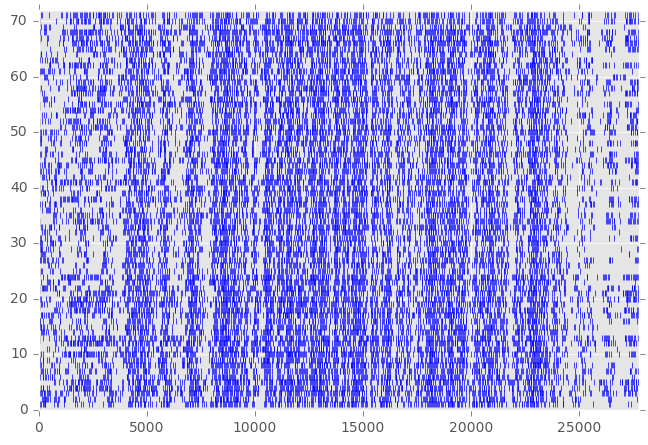

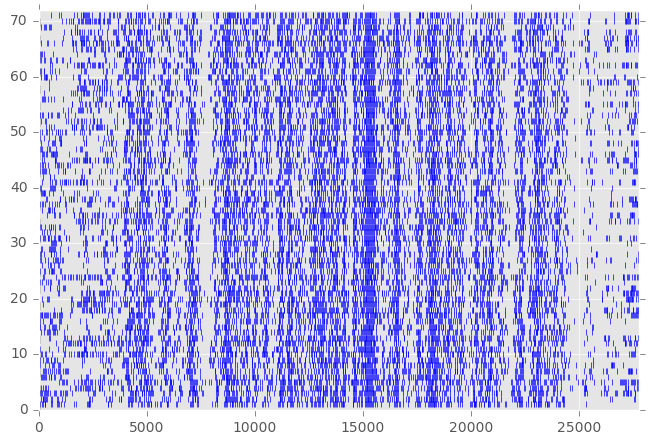

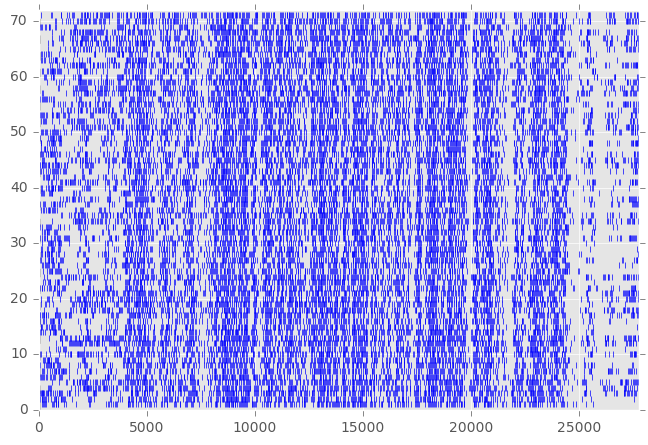

In [64]:
spike_thresh = 4.5
thresh = rms*spike_thresh
all_spk_arr = collect_all_spk_arr(all_frames, thresh, min_dist=20)
for i in range(neural_chans.size):
    plt.figure()
    #plt.plot(all_spk_arr.mean(axis=0)[:,i])
    bp.plot_raster(all_spk_arr[:,:,i])

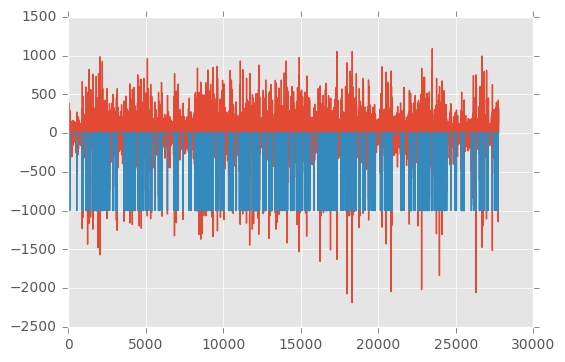

In [48]:
fr_n = 9
ch_n = 2
plt.plot(all_frames[fr_n].data[:, ch_n])
plt.plot(all_spk_arr[fr_n,:,ch_n]*(-1000));


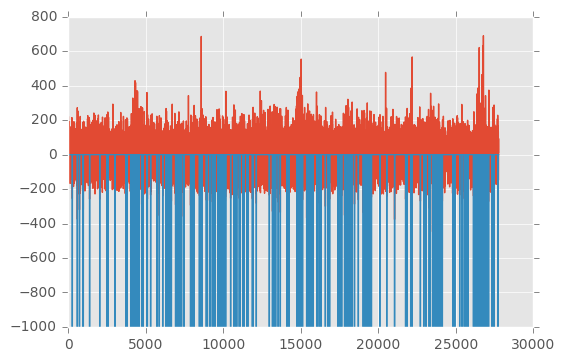

In [45]:
fr_n = 16
ch_n = 1
plt.plot(all_frames[fr_n].data[:, ch_n])
plt.plot(all_spk_arr[fr_n,:,ch_n]*(-1000));

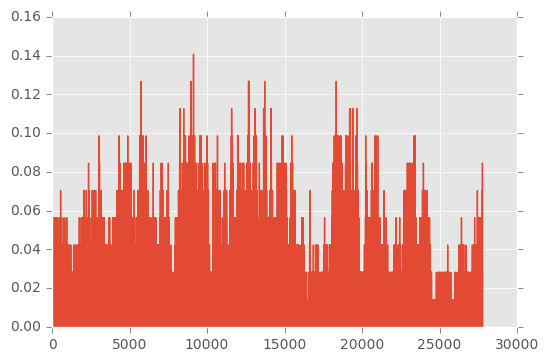

In [144]:
plt.plot(all_spk_arr.mean(axis=0)[:,0])

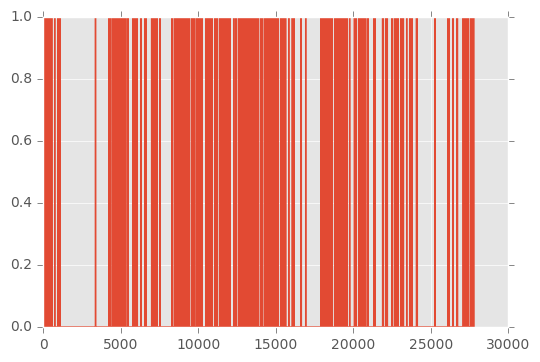

In [139]:
plt.plot(all_spk_arr[2,:,5])

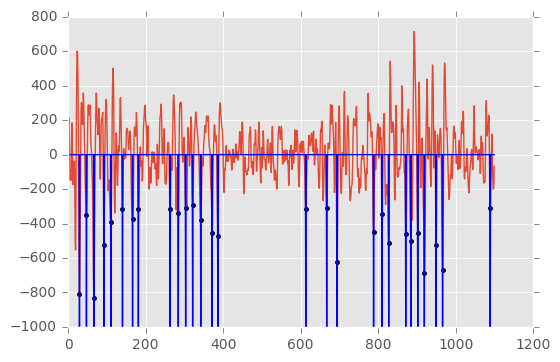

In [45]:
tfr.data.shape

(1100, 6)

In [133]:
reload(tp)
spks = tp.find_spikes(tfr.data, thresh*2, min_dist=10)

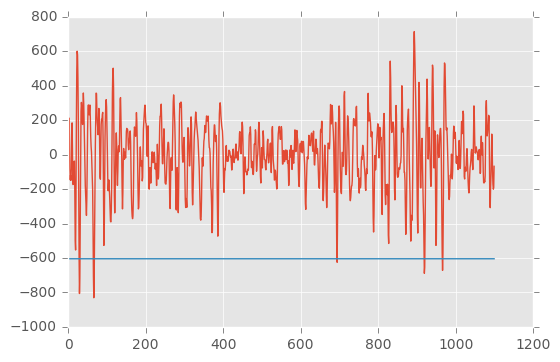

In [134]:
plt.plot(tfr.data[:,chan])
plt.plot(spks[chan], tfr.data[spks[chan], chan], 'k.')
plt.plot(-np.ones_like(tfr.data[:,chan])*thresh[chan])

In [36]:
frames = []
all_spectra = []
before = 10000
after = 10000

spectra = []

for i_bout, start in enumerate(starts):
    if i_bout%50 == 0:
        print("Bout {} ...".format(i_bout))
    rec = recs[i_bout]
    one_frame = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec), 
                                     s_f, 
                                     dtype=np.float), 
                           np.array(neural_chans),
                           [start-before, start + m_chunk.samples + after])
    one_frame.apply_filter(sp.apply_butter_bandpass, filter_pars)
    one_frame.apply_filter(np.abs)
    frames.append(one_frame)
    #spectra = [sp.Spectrogram(one_frame.data[:,ch], s_f, **lfp_spectro_pars) for ch in neural_chans]
    #all_spectra.append([spectra[0]] + [list_sum(spectra)])




Bout 0 ...
Bout 50 ...


(<matplotlib.figure.Figure at 0x7f154a6f8090>,
 <matplotlib.axes._axes.Axes at 0x7f152bbea1d0>)

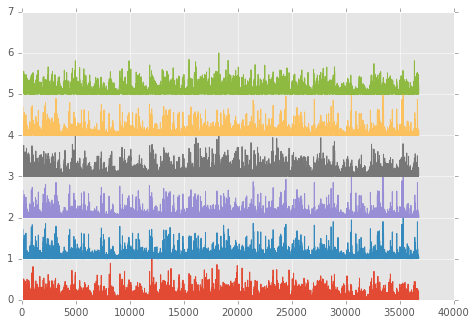

In [40]:
frames[6].plot()

(<matplotlib.figure.Figure at 0x7f153056fdd0>,
 <matplotlib.axes._axes.Axes at 0x7f153041a150>)

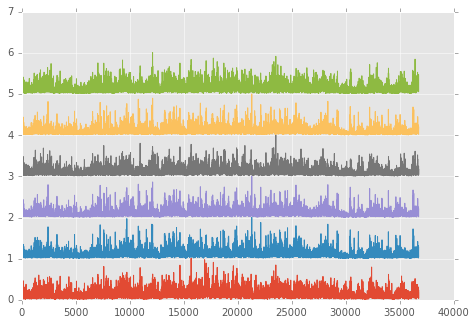

In [39]:
list_sum(frames).plot()

890.666666667
890.666666667


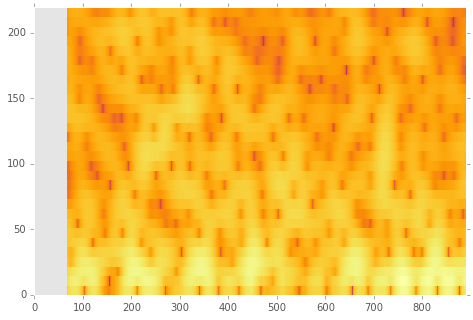

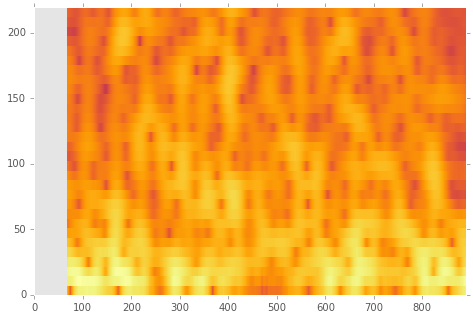

In [58]:
all_spectra[0][0].plot()
all_spectra[0][1].plot()

In [13]:
all_spectra[2]

890.666666667
890.666666667
890.666666667
890.666666667
890.666666667
890.666666667
890.666666667
890.666666667
890.666666667
890.666666667


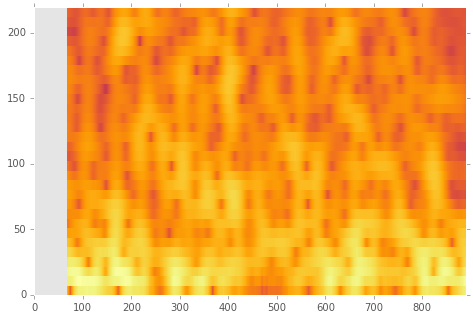

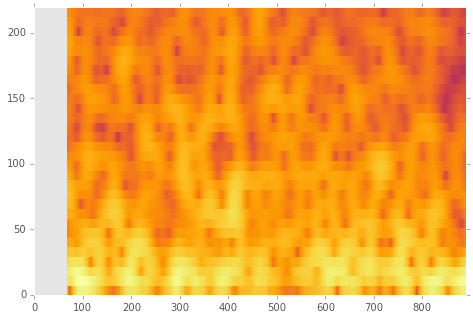

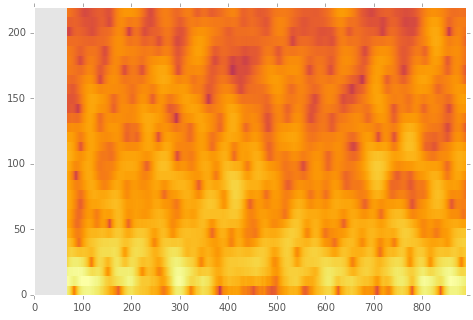

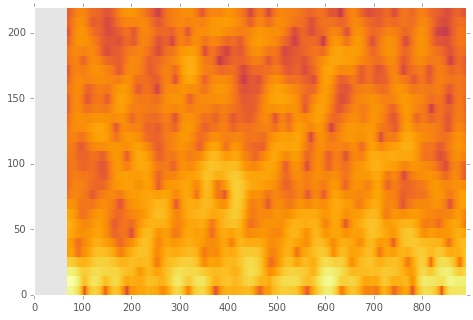

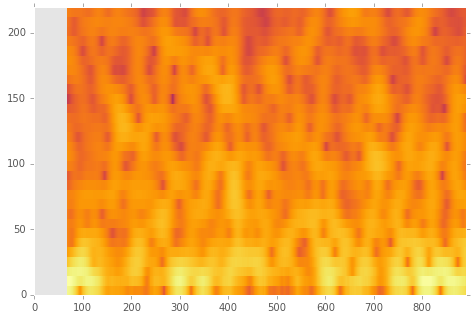

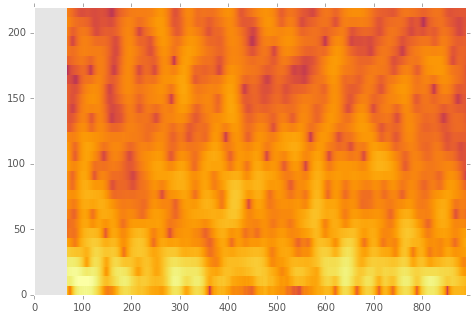

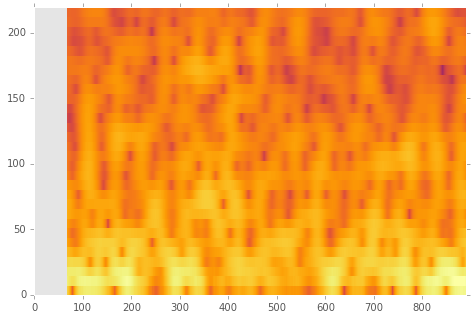

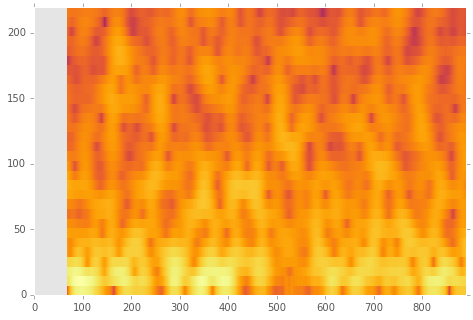

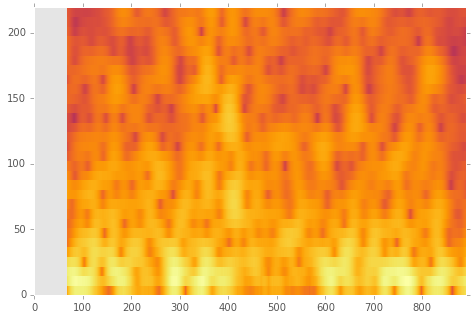

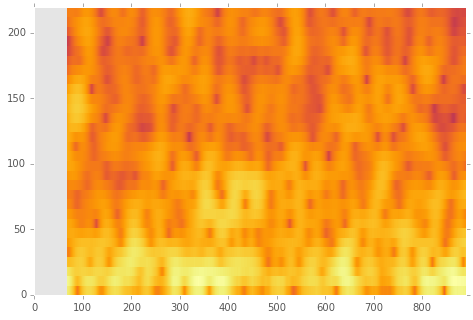

In [14]:
for ch in range(10):
    all_spectra[ch][1].plot()

850.4


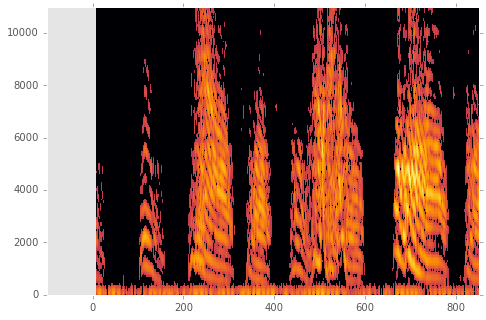

In [16]:
i_bout = 53

rec = recs[i_bout]
start = starts[i_bout]

lfp_frame_2 = st.Chunk(st.H5Data(kwdf.get_data_set(kwd_file, rec), s_f, dtype=np.float),
                     np.array(neural_chans),
                     [start-before, start + m_chunk.samples + after])

spec_chan_2 = sp.Spectrogram(lfp_frame_2.data[:,chan], s_f, **lfp_spectro_pars)
ax_2=spec_chan_2.plot(before_ms=100)

In [18]:
sp3 = spec_chan + spec_chan_2

850.4


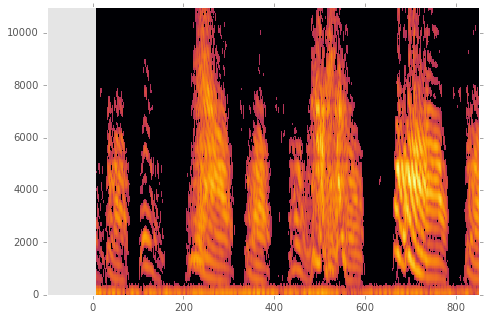

In [19]:
sp3.plot(before_ms=100)

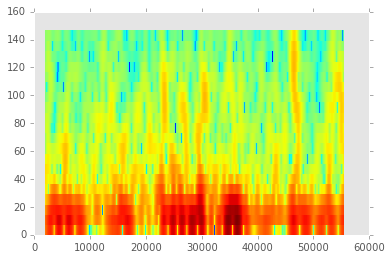

In [80]:
f_cut = 150
n_window = 2048*2
n_overlap = n_window-8

response_spectrogram = spectrogram(lfp_frame.data[:, 1], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*15), 
                                  scaling='spectrum')

plt.pcolormesh(response_spectrogram[1]*s_f, 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))

In [81]:
# quick confirm of the avg lfp
n_trials = starts.size - 1
n_samples = m_chunk.samples + after + before
n_chans = neural_chans.size

spectr_shape = response_spectrogram[2].shape
n_x = spectr_shape[0]
n_y = spectr_shape[1]

spectr = np.empty([n_trials, n_x, n_y])
lfp = np.empty([n_samples, n_trials, n_chans], dtype=np.float)


for i_trial in range(n_trials):
    start = starts[i_trial]
    one_frame = st.Chunk(h5d, np.array(neural_chans), [start-before, start + m_chunk.samples + after])
    lfp[:, i_trial, :] = one_frame.data
    this_spectrogram = spectrogram(one_frame.data[:, 1], s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*50), 
                                  scaling='density')
    spectr[i_trial, :, :] = (this_spectrogram[2])

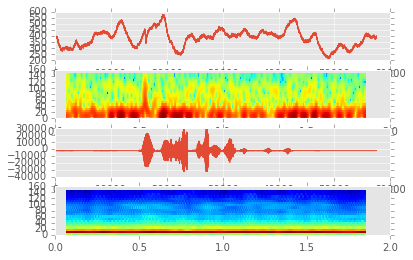

In [83]:
f_cut = 150
n_window = 4096
n_overlap = n_window-8
response_spectrogram = spectrogram(np.mean(lfp[:, :, 1], axis=1), s_f, 
                                  nperseg = n_window, 
                                  noverlap= n_overlap, 
                                  window = sg.gaussian(n_window, sigma*10), 
                                  scaling='spectrum')
plt.figure(3)
plt.subplot(411)
plt.plot(np.mean(lfp[:, :, 1], axis=1))
plt.subplot(412)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(response_spectrogram[2][response_spectrogram[0] < f_cut, :]))
plt.subplot(413)
plt.plot(lfp[:,4,0])
plt.subplot(414)
plt.pcolormesh(response_spectrogram[1], 
               response_spectrogram[0][response_spectrogram[0] < f_cut], 
               np.log(mean_spectr[:,:][response_spectrogram[0] < f_cut, :]))
fig_name = os.path.join(fn['folders']['ss'], 'spectrum_avg_{}.png'.format(m_name))
plt.savefig(fig_name, format='png')
plt.show()
